In [41]:
import os, numpy as np, pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv("SRP181622/SRP181622.tsv", sep="\t", index_col=0)
metadata = pd.read_csv("SRP181622/metadata_SRP181622.tsv", sep="\t", index_col=0)

In [43]:
counts_df = df.copy()
counts_df = counts_df.apply(pd.to_numeric, errors='coerce').fillna(0)
counts_df = counts_df.round().astype(int)
meta_df = metadata.reindex(counts_df.columns).copy()

In [44]:
def _mk_group(row):
    text = " ".join(str(row.get(c, "")) for c in [
        "refinebio_title", "refinebio_description", "refinebio_biological_condition"
    ])
    text_l = text.lower()
    is_control = re.search(r'\b(control|ctrl|normal|baseline|untreated|wild[- ]type)\b', text_l)
    is_stress  = re.search(r'\b(stress|treated|treatment|heat|drought|hypoxia|drug|injury|disease)\b', text_l)
    if is_control and not is_stress:
        return "Control"
    if is_stress and not is_control:
        return "Stress"
    if "control" in text_l:
        return "Control"
    return "Stress"

In [45]:
if 'group' not in meta_df.columns or meta_df['group'].isna().all():
    meta_df['group'] = meta_df.apply(_mk_group, axis=1)

if not (meta_df.index == counts_df.columns).all():
    raise ValueError("metadata indices must match counts columns (sample IDs). Check your files.")

gA = meta_df.index[meta_df['group'].str.lower() == 'control'].tolist()
gB = meta_df.index[meta_df['group'].str.lower() == 'stress' ].tolist()

In [46]:
missing_in_meta = [c for c in counts_df.columns if c not in meta_df.index]
print("samples in counts_df but not in meta_df:", len(missing_in_meta))

print(meta_df[['refinebio_title','group']].head(8))

samples in counts_df but not in meta_df: 0
            refinebio_title    group
SRR8477377  PFC_Control1_C1  Control
SRR8477378  PFC_Control1_C1  Control
SRR8477379  PFC_Control1_C1  Control
SRR8477380  PFC_Control2_C2  Control
SRR8477381  PFC_Control2_C2  Control
SRR8477383  PFC_Control2_C2  Control
SRR8477384  PFC_Control2_C2  Control
SRR8477385  PFC_Control3_C3  Control


In [47]:
expr = np.log2(counts_df[gA + gB] + 1)

rows = []
xvar = expr[gA].var(axis=1, ddof=1).to_numpy()
yvar = expr[gB].var(axis=1, ddof=1).to_numpy()

In [48]:
rows = []
for gene, row in expr.iterrows():
    x = row[gA].to_numpy(dtype=float)
    y = row[gB].to_numpy(dtype=float)
    if len(x) >= 2 and len(y) >= 2 and (np.var(x) > 0 or np.var(y) > 0):
        t, p = stats.ttest_ind(x, y, equal_var=False, nan_policy='omit')
    else:
        p = np.nan
    l2fc = np.nanmean(y) - np.nanmean(x)
    rows.append((gene, l2fc, p))

res_py = pd.DataFrame(rows, columns=['gene','log2FC','pval'])

In [49]:
# --- 4. Adjust p-values (FDR) ---
res_py['padj'] = 1.0  # default
finite_mask = np.isfinite(res_py['pval'])
if finite_mask.any():
    res_py.loc[finite_mask,'padj'] = multipletests(
        res_py.loc[finite_mask,'pval'], method='fdr_bh'
    )[1]

# --- 5. Save outputs ---
res_py.to_csv("results/python_all_results.csv", index=False)
res_py.nsmallest(50, 'padj').to_csv("results/python_top50.csv", index=False)
print("Saved CSVs to results/")


Saved CSVs to results/


In [54]:
# --- 6. Volcano plot ---
eps = np.finfo(float).tiny
x = res_py['log2FC'].to_numpy()
p = np.clip(res_py['padj'].to_numpy(), eps, 1.0)
y = -np.log10(p)

fc_thr = 1.0
p_thr  = 0.05
sig = (np.abs(x) >= fc_thr) & (p < p_thr)

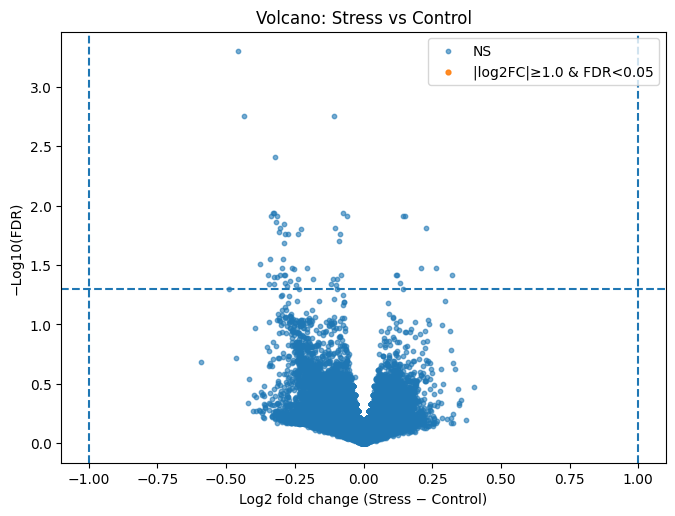

In [55]:
plt.figure(figsize=(7.8,5.6))
plt.scatter(x[~sig], y[~sig], s=10, alpha=0.6, label='NS')
plt.scatter(x[sig],  y[sig],  s=12, alpha=0.9, label=f'|log2FC|≥{fc_thr} & FDR<{p_thr}')
plt.axvline(+fc_thr, ls='--'); plt.axvline(-fc_thr, ls='--'); plt.axhline(-np.log10(p_thr), ls='--')
plt.xlabel('Log2 fold change (Stress − Control)')
plt.ylabel('−Log10(FDR)')
plt.title('Volcano: Stress vs Control')
plt.legend(loc='upper right')

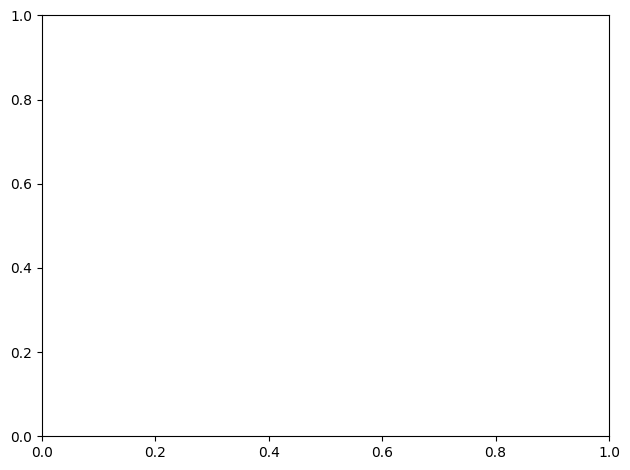

Saved plot -> results/volcano_python_matplotlib.png


In [56]:
for _, r in res_py.nsmallest(10, 'padj').iterrows():
    plt.annotate(r['gene'], (r['log2FC'], -np.log10(max(r['padj'], eps))),
                 fontsize=7, xytext=(3,3), textcoords='offset points')

plt.tight_layout()
plt.savefig("results/volcano_python_matplotlib.png", dpi=300)
plt.show()
print("Saved plot -> results/volcano_python_matplotlib.png")

In [57]:
sig_df = res_py.query('padj < @p_thr')
up = (sig_df['log2FC'] > 0).sum()
down = (sig_df['log2FC'] < 0).sum()
total = len(res_py)
print(f"Total genes: {total} | Significant (FDR<{p_thr}): {len(sig_df)} | Up: {up} | Down: {down}")

summary = (
    f"We compared Stress vs Control using Welch’s t-test per gene on log2(count+1) expression "
    f"with Benjamini–Hochberg FDR control. Out of {total} genes, {len(sig_df)} were significant "
    f"at FDR < {p_thr}, with {up} up-regulated and {down} down-regulated in Stress. "
    f"Full results: results/python_all_results.csv; Top-50: results/python_top50.csv; "
    f"Volcano: results/volcano_python_matplotlib.png."
)
print("\nREPORT SUMMARY:\n" + summary)

Total genes: 41249 | Significant (FDR<0.05): 61 | Up: 10 | Down: 51

REPORT SUMMARY:
We compared Stress vs Control using Welch’s t-test per gene on log2(count+1) expression with Benjamini–Hochberg FDR control. Out of 41249 genes, 61 were significant at FDR < 0.05, with 10 up-regulated and 51 down-regulated in Stress. Full results: results/python_all_results.csv; Top-50: results/python_top50.csv; Volcano: results/volcano_python_matplotlib.png.


In [ ]:
sig_df = res_py.query('padj < 0.05')
up = (sig_df['log2FC'] > 0).sum()
down = (sig_df['log2FC'] < 0).sum()
print(f"Total genes: {len(res_py)}")
print(f"Significant (FDR<0.05): {len(sig_df)} | Up: {up} | Down: {down}")